<div style="text-align: center; margin: 50px">

<h1 style="text-align: center;">Qubit by Qubit</h1>
<h2 style="text-align: center;">Introduction to Quantum Computing</h1>
<h3>Week 22 - Benchmarking Quantum Circuits</h3>

</div>

In [12]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
import matplotlib.pyplot as plt

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-10 22:01:36,597: Credentials are already in use. The existing account in the session will be replaced.


## Coding cheat sheet:

`qc = QuantumCircuit(2)` # Define a 2 qubit quantum circuit <br>
`qc = QuantumCircuit(2,2)` # Define a 2 qubit quantum circuit with 2 classical bit (Only for QASM simulator or real Quantum Computer) <br>

`qc.x(0)` #Add an X gate <br>
`qc.h(0)` #Add an H gate <br>
`qc.z(0)` #Add a Z gate <br>

`qc.measure([0,1],[0,1])` # Add measurement to circuit (Only for QASM simulator or real Quantum Computer) <br>

`qc.draw()` # Draw the circuit <br>


### Set up and run the statevector simulator:<br>

`backend = Aer.get_backend('statevector_simulator')` # Tell it which simulator you want to use <br>
`job = execute(qc,backend)` # Put in the name of your quantum circuit where it says qc<br>
`result = job.result()` <br>

### Set up and run the QASM simulator:<br>

`backend = Aer.get_backend('qasm_simulator')` # Tell it which simulator you want to use <br>
`job = execute(qc,backend, shots = 1024)` # Put in the name of your quantum circuit where it says qc, and the number of shots you want to use<br>
`result = job.result()` <br>

### Set up and run on a real quantum computer :<br>
`from qiskit.providers.ibmq import least_busy` <br>
`backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and` <br>
                                        `not x.configuration().simulator and x.status().operational==True))` # Find the least busy QC <br>

`job = execute(qc,backend, shots = 1024)` # Put in the name of your quantum circuit where it says qc, and the number of shots you want to use<br>
`result = job.result()` <br>


### See the output in vector form (only for Statevector simulator):<br>
`state = result.get_statevector()` <br>
`array_to_latex(state, prefix="\\text{Statevector} = ")` <br>

### See the output in histogram form (for Statevector, QASM, or real quantum computer): <br>
`counts = result.get_counts()` <br>
`plot_histogram(counts)` <br>


## Creating noise models

Today, we are going to test how many errors we get when we run circuits on real quantum computers. To measure these errors, we will run circuits of different lengths on the quantum computers - just like the game of whispers, we expect the number of errors to go up as the length of our circuits increases. 

However, there's one problem - it takes a long time to run a single circuit on a real device! The queues on IBM's quantum computers are really long. If we actually tried to run each circuit on real devices, it would take us a really long time to get results.

Fortunately, there is a workaround. IBM provides **noise models** that allow simulators to mimic the behavior of different QCs! These noise models are created after extensively testing each of the QCs and finding out the rate at which they produce errors. Each QC provided by IBM has its own noise model. We will be using these noise models today to quickly get results on errors from different QCs! 

Let's create a noise model based on `ibmq_belem`. We will use this noise model in all our simulations to mimic the results we would have gotten on `ibmq_belem`.

To create a noise model, we first specify which backend we want to create the model from, and then use Qiskit's `NoiseModel` function to create the noise model for that backend.

In [13]:
backend_belem = provider.get_backend('ibmq_belem')   # Specifying which backend to use
noise_model_belem = NoiseModel.from_backend(backend_belem)  # Creating a noise model from this backend.

We will use this noise model when we simulate our circuits. 

## Errors in single qubit circuits

We are now ready to create benchmarking circuits to measure noise in our QC! 

Remember that our goal is to create circuits of different lengths whose final state is |0> for every qubit in the circuit. Any deviation from this final state is an error, and we can measure the rate of errors for circuits of different lengths.

Let's start off small - we'll create a single qubit circuit whose final state is |0>. Our circuit will have two X gates - the first puts the qubit in the |1> state, and the second puts it back in the |0> state.

Further, as we discussed earlier, we will be placing barriers between each gate, so that we can visually distinguish different parts of our circuit. These barriers do not change anything about the circuit - they are just visual aids.

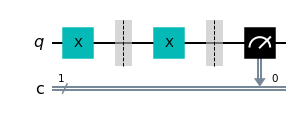

In [14]:
# Block 1 - This block creates a quantum circuit with 1 qubit, and adds two X gates to the circuit.
# There is a barrier between the two gates
qc = QuantumCircuit(1,1)
qc.x(0)   # First X gate
qc.barrier() # Barrier
qc.x(0) # Second X gate
qc.barrier() # Barrier

qc.measure(0,0)
qc.draw()

Your turn! Can you think of a different single qubit circuit that produces |0> at the end? You can use as many gates as you want (use atleast two!). Also remember to place barriers between each gate in your circuit

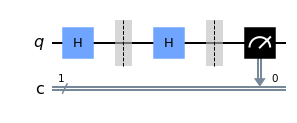

In [27]:
# Block 2 - Create a quantum circuit with 1 qubit and 1 classical bit that would produce |0> as its final state
# Remember to add a barrier between each gate in your circuit.
# At the end of your circuit, add a measurement.
qc = QuantumCircuit(1,1)
qc.h(0)   # First X gate
qc.barrier() # Barrier
qc.h(0) # Second X gate
qc.barrier() # Barrier

qc.measure(0,0)
qc.draw()

Let's run your circuit! The code below uses the noise model we had created to simulate the circuit using the QASM simulator.

Add code to display the result as a histogram - how many errors did you get?

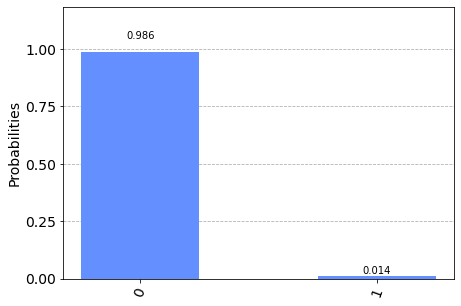

In [28]:
# Block 3 - Simulating your circuit using the belem noise model
# YOU NEED TO ADD CODE IN THIS BLOCK
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, noise_model=noise_model_belem, shots = 1024)
result = job.result()# Fill in code to get results
counts = result.get_counts()#Fill in code to get counts from results

# Add code here to display the counts as a histogram
plot_histogram(counts)

So, you can see that we got a few errors with your simple, 1-qubit circuit. Next, we will explore how these errors scale as you increase the number of qubits and the size of your circuit.

## Errors in 2-qubit circuits

Let's try to do the same thing, but with 2 qubits. Can you create a 2 qubit circuit whose final state is |00>? Extra points for creativity - feel free to use H gates, X gates, Z gates, CX gates, Rx gates....

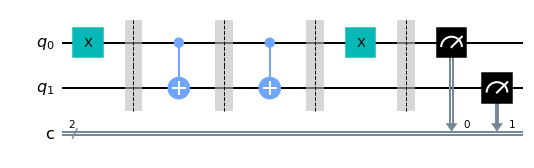

In [31]:
# Block 4 - Create a 2-qubit circuit whose final state is |00>, i.e., both qubits are in the |0> state at the end
qc = QuantumCircuit(2,2)
qc.x(0)
qc.barrier()
qc.cx(0,1)
qc.barrier()
qc.cx(0,1)
qc.barrier()
qc.x(0)
qc.barrier()
qc.measure([0,1],[0,1])
qc.draw()

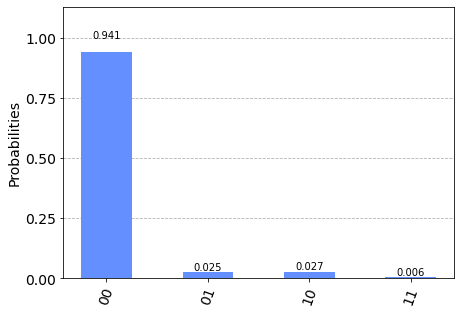

In [32]:
# Block 5 - Simulate your circuit using the belem noise model.
# How many errors do you get? Is it more or less than the single qubit circuit?
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, noise_model=noise_model_belem, shots = 1024)
result = job.result()# Fill in code to get results
counts = result.get_counts()#Fill in code to get counts from results

# Add code here to display the counts as a histogram
plot_histogram(counts)

### Discussion: You will notice that you get more errors with two qubits than with 1 qubit. Why do you think this is?

## Creating benchmarking circuits

We are now ready to create benchmarking circuits of different lengths and test how the errors scale with different lengths of the circuit. To do this, you will use the same 2-qubit circuit you had come up with in the previous blocks, and **repeat** it several times. The more times you repeat, the longer the circuit, and the more errors you will see!

### How can we easily repeat the same gates?

Which programming tool would you use to easily repeat the same code multiple times?

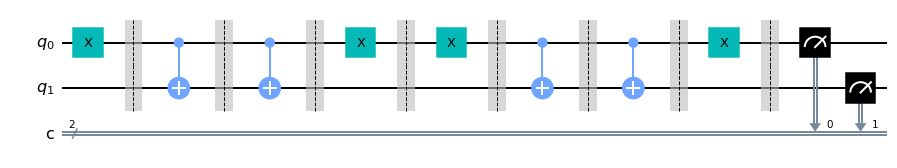

In [8]:
# Block 6 - Using the same gates as you had in block 4, create circuits of different lengths
# You should use between 1 and 20 repetitions of your circuit
# Remember to add barriers between each gate!
# Add measurements to your circuit at the end
# How many errors do you get? How do these errors change with the size of your circuit?
qc = QuantumCircuit(2,2)
for i in range(2):
    qc.x(0)
    qc.barrier()
    qc.cx(0,1)
    qc.barrier()
    qc.cx(0,1)
    qc.barrier()
    qc.x(0)
    qc.barrier()
qc.measure(0,0)
qc.measure(1,1)
qc.draw()

In [41]:
# Block 7 - Simulate your circuit using the belem noise model. 
# How many errors do you get? How do these errors change with the size of your circuit?

backend = Aer.get_backend('qasm_simulator')
job_belem = execute(qc, backend, noise_model=noise_model_belem, shots = 1024)
result_belem = job_belem.result()# Fill in code to get results
counts_belem = result_belem.get_counts()#Fill in code to get counts from results
print(counts_belem)

{'01': 354, '10': 146, '00': 375, '11': 149}


### Test out how many errors you get for different numbers of repetitions of your circuit.

## Creating a plot of how errors scale with circuit length

Let's end our lab by visualizing the scaling of errors with circuit length. 

The code below creates a plot of the fraction of errors versus the number of repetitions of your circuit. You have to put in your simple 2-qubit circuit, and the code will automatically generate different numbers of repetitions and calculate errors.

Completed running circuit 1 out of 13
Completed running circuit 2 out of 13
Completed running circuit 3 out of 13
Completed running circuit 4 out of 13
Completed running circuit 5 out of 13
Completed running circuit 6 out of 13
Completed running circuit 7 out of 13
Completed running circuit 8 out of 13
Completed running circuit 9 out of 13
Completed running circuit 10 out of 13
Completed running circuit 11 out of 13
Completed running circuit 12 out of 13
Completed running circuit 13 out of 13


Text(0, 0.5, 'probability of getting the right answer')

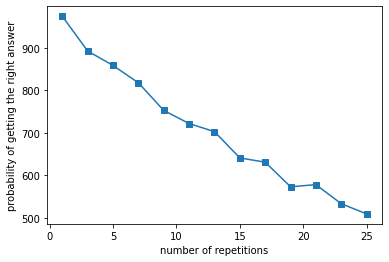

In [26]:
# Block 8 - Creating a plot of the number of errors for differnet circuit lengths. 
# YOU NEED TO ADD CODE FOR THIS BLOCK TO WORK!

circuit_lengths = [1,3,5,7,9,11,13,15,17,19,21,23,25]
correct_results =[]
ctr = 0
for i in circuit_lengths:
    ctr = ctr+1
    qc = QuantumCircuit(2,2)
    for j in range(i):
        #Add your circuit from the Block 6 here! Make sure you get the indentation right
        qc.x(0)
        qc.barrier()
        qc.cx(0,1)
        qc.barrier()
        qc.cx(0,1)
        qc.barrier()
        qc.x(0)
        qc.barrier()
        qc.measure(0,0)
        qc.measure(1,1)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, noise_model=noise_model_belem, shots = 1024)
    result = job.result()# Fill in code to get results
    counts = result.get_counts()#Fill in code to get counts from results
    correct_results.append(counts["00"])
    print("Completed running circuit " + str(ctr) + " out of " + str(len(circuit_lengths)))

plt.plot(circuit_lengths,correct_results,marker = 's')
plt.xlabel('number of repetitions')
plt.ylabel('probability of getting the right answer')

As you can see, errors increase with length of circuit! Until how many repetitions would you consider the results of this circuit "fairly accurate"?

Metrics such as these are really important in engineering quantum computers! The maximum length of circuit that can be reliably computed is really important - the longer the circuit can be, the more sophisticated computations we can do with it!

# Optional content - Comparing two quantum computers

We can use benchmarking to compare two different quantum computers, and check with of them produces fewer errors for different circuit lengths!

First, let's create a second noise model - we will use `ibmq_quito`.

In [36]:
# Optional block 1 - Creating a second noise model
backend_quito = provider.get_backend('ibmq_quito')   # Specifying which backend to use
noise_model_quito = NoiseModel.from_backend(backend_quito)  # Creating a noise model from this backend.

Next, we will test out your simple 2-qubit circuit on both noise models, and see which one produces more errors.

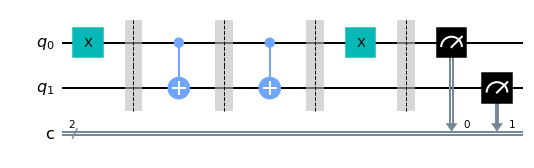

In [33]:
# Optional Block 2 - Create a 2-qubit circuit that will produce the final state |00>. 
# You can use the same simple circuit you had used before.
# Do not add any repetitions here - we will test those out later.
qc = QuantumCircuit(2,2)
qc.x(0)
qc.barrier()
qc.cx(0,1)
qc.barrier()
qc.cx(0,1)
qc.barrier()
qc.x(0)
qc.barrier()
qc.measure([0,1],[0,1])
qc.draw()

In [38]:
# Optional Block 3 - Simulate your circuit using the belem noise model.
# How many errors do you get?
backend = Aer.get_backend('qasm_simulator')
job_belem = execute(qc, backend, noise_model=noise_model_belem, shots = 1024)
result_belem = job_belem.result()# Fill in code to get results
counts_belem = result_belem.get_counts()#Fill in code to get counts from results
print(counts_belem)

{'11': 3, '10': 31, '00': 967, '01': 23}


In [39]:
# Optional Block 4 - Simulate your circuit using the quito noise model.
# How many errors do you get? Is it more or less than belem?
backend = Aer.get_backend('qasm_simulator')
job_quito = execute(qc, backend, noise_model=noise_model_quito, shots = 1024)
result_quito = job_quito.result()# Fill in code to get results
counts_quito = result_quito.get_counts()#Fill in code to get counts from results
print(counts_quito)

{'11': 2, '01': 28, '10': 13, '00': 981}


Let's study how the errors scale with the size of the circuit for both noise models! In the block below, create a 2 qubit circuit named qc and add the same gates to it as in optional block 2. The block will measure errors for differnet numbers of repetitions and plot them.

Completed running circuit 1 out of 13
Completed running circuit 2 out of 13
Completed running circuit 3 out of 13
Completed running circuit 4 out of 13
Completed running circuit 5 out of 13
Completed running circuit 6 out of 13
Completed running circuit 7 out of 13
Completed running circuit 8 out of 13
Completed running circuit 9 out of 13
Completed running circuit 10 out of 13
Completed running circuit 11 out of 13
Completed running circuit 12 out of 13
Completed running circuit 13 out of 13


Text(0, 0.5, 'probability of getting the right answer')

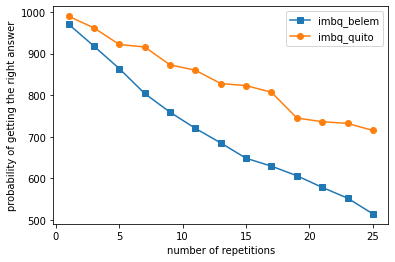

In [45]:
# Optional Block 5 - Measuring errors for lima and belem!
# Create a 2-qubit quantum circuit and add the same gates to it as in Optinal Block 2.
# Run the block to produce a plot of the errors produced by lima and belem
circuit_lengths = [1,3,5,7,9,11,13,15,17,19,21,23,25]
correct_results_belem =[]
correct_results_quito =[]
ctr = 0
for i in circuit_lengths:
    ctr = ctr+1
    qc = QuantumCircuit(2,2)
    for j in range(i):
        #Add your circuit from the Block 6 here! Make sure you get the indentation right
        qc.x(0)
        qc.barrier()
        qc.cx(0,1)
        qc.barrier()
        qc.cx(0,1)
        qc.barrier()
        qc.x(0)
        qc.barrier()
    qc.measure(0,0)
    qc.measure(1,1)
    backend = Aer.get_backend('qasm_simulator')
    job_belem = execute(qc, backend, noise_model=noise_model_belem, shots = 1024)
    result_belem = job_belem.result()# Fill in code to get results
    counts_belem = result_belem.get_counts()#Fill in code to get counts from results
    correct_results_belem.append(counts_belem["00"])
    job_quito = execute(qc, backend, noise_model=noise_model_quito, shots = 1024)
    result_quito = job_quito.result()# Fill in code to get results
    counts_quito = result_quito.get_counts()#Fill in code to get counts from results
    correct_results_quito.append(counts_quito["00"])
    print("Completed running circuit " + str(ctr) + " out of " + str(len(circuit_lengths)))

plt.plot(circuit_lengths,correct_results_belem,marker = 's')
plt.plot(circuit_lengths,correct_results_quito,marker = 'o')
plt.legend(['imbq_belem','imbq_quito'])
plt.xlabel('number of repetitions')
plt.ylabel('probability of getting the right answer')

### Which QC produced fewer errors? Which one do you think is more reliable? Does this match with your analysis of the error rates from earlier in the lab?